# `huracanpy` basic use for assessing storm climatology in a dataset
Here, we examplify usage of `huracanpy` with the dataset of TC in ERA-20C detected by the TRACK algorithm.
This is meant to show an example of workflow. Please refer to specific parts of the documentation to learn about each part (e.g. loading, plotting, etc.) in more detail.

In [1]:
import huracanpy

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs

## Read the file
`huracanpy`'s `load` function can handle different track file types. Here, the data is available as a netcdf file.

In [2]:
data = huracanpy.load(
    "data/NATL.nc",
).reset_coords()[["psl", "wind_speed_10m", "time", "latitude", "longitude", "track_id"]]
# Reset coords and subset variable due to the format of this specific file from TRACK
data.psl.attrs["units"] = "hPa"  # Fixing misspelled pressure unit

## Add useful information
After loading, you can add various useful information for the analysis (basin, season, category...)

In [3]:
# Preliminary available variables
list(data.variables.keys())

['psl', 'wind_speed_10m', 'time', 'latitude', 'longitude', 'track_id']

In [4]:
# Apply add_all_info to add a number of useful attributes.
data = huracanpy.utils.add_all_info(
    data,
    lat_name="latitude",
    lon_name="longitude",
    wind_name="wind_speed_10m",
    slp_name="psl",
    slp_units="hPa",
)
# If you want to add individually the one you need instead, have a look at the functionning of the utils module itself.

In [5]:
# New list of variables
list(data.variables.keys())

['psl',
 'wind_speed_10m',
 'time',
 'latitude',
 'longitude',
 'track_id',
 'hemisphere',
 'basin',
 'is_ocean',
 'country',
 'continent',
 'season',
 'sshs',
 'pres_cat']

# Check the content of the file
`huracanpy` provide a coarse plotting function that you can use for checking what is in your data. 

(<Figure size 1000x1000 with 1 Axes>,
 <GeoAxes: xlabel='longitude', ylabel='latitude'>)

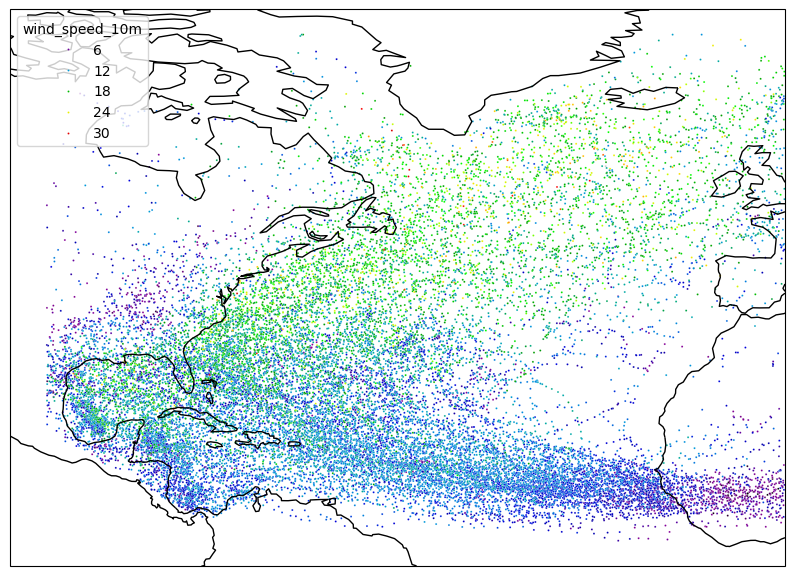

In [6]:
# Basic plot of the data points
huracanpy.plot.tracks.plot_tracks_basic(
    data.longitude,
    data.latitude,
    data.wind_speed_10m,
)

## Climatological metrics
You can compute basic statistics: frequency, TC days, ACE. Here shown as yearly averages.

In [7]:
# Frequency (Number of track per year)
huracanpy.diags.climato.freq(data, by="season")

<xarray.DataArray ()> Size: 8B
array(5.61111111)

In [8]:
# TCD (Accumulated duration of storms per year)
huracanpy.diags.climato.TC_days(data, by="season")

<xarray.DataArray 'duration' ()> Size: 8B
array(56.71990741)

In [9]:
# ACE (aggregated per year)
huracanpy.utils.ace.ace_by_point(
    data.wind_speed_10m, threshold=0, wind_units="m s**-1"
).groupby(data.season).sum().mean()

<xarray.DataArray ()> Size: 4B
array(15.185588, dtype=float32)

## Variability
With xarray's grouping functionnalities, you can show variations of these statistics. 

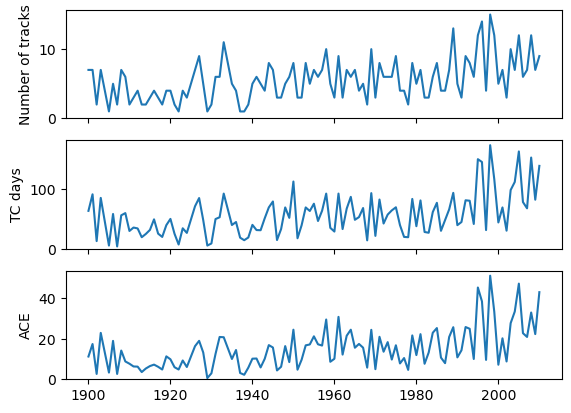

In [10]:
## Interannual

fig, axs = plt.subplots(3, sharex=True)
# Frequency
data.groupby("season").apply(huracanpy.diags.climato.freq).plot(ax=axs[0])
axs[0].set_ylabel("Number of tracks")
# TCD
data.groupby("season").apply(huracanpy.diags.climato.TC_days).plot(ax=axs[1])
axs[1].set_ylabel("TC days")
# ACE
data.groupby("season").apply(
    lambda x: huracanpy.diags.climato.ACE(x, wind_name="wind_speed_10m")
).plot(ax=axs[2])
axs[2].set_ylabel("ACE")

for ax in axs:
    ax.set_ylim(0)
    ax.set_xlabel("")

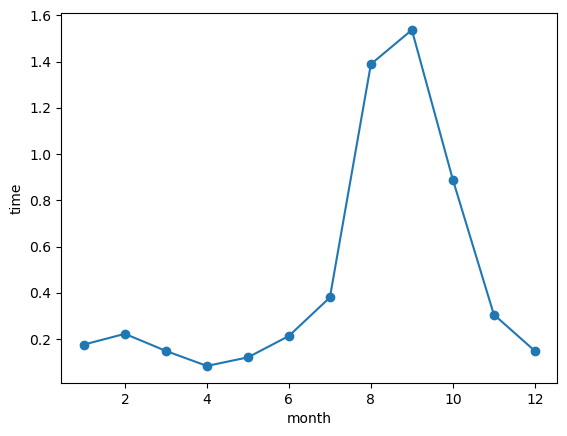

In [11]:
## Seasonal

gen = huracanpy.diags.track_stats.gen_vals(
    data,
)  # Extract the point of genesis for each track
(
    gen.groupby("time.month").count().time  # compute number of tracks per month
    / gen.season.nunique()  # Normalize by number of season
).plot(marker="o")  # plot
# NB: Could be made simpler if only xarray would support grouping by several variables

## Track statistics
You can also compute track-level statistics such as duration and lifetime maximum intensity.

(array([  6.,  17.,  34.,  51.,  58.,  77.,  89., 235.,  37.,   2.]),
 array([ 941.6126709 ,  950.1151001 ,  958.6175293 ,  967.1199585 ,
         975.6223877 ,  984.12481689,  992.62724609, 1001.12967529,
        1009.63210449, 1018.13453369, 1026.63696289]),
 <BarContainer object of 10 artists>)

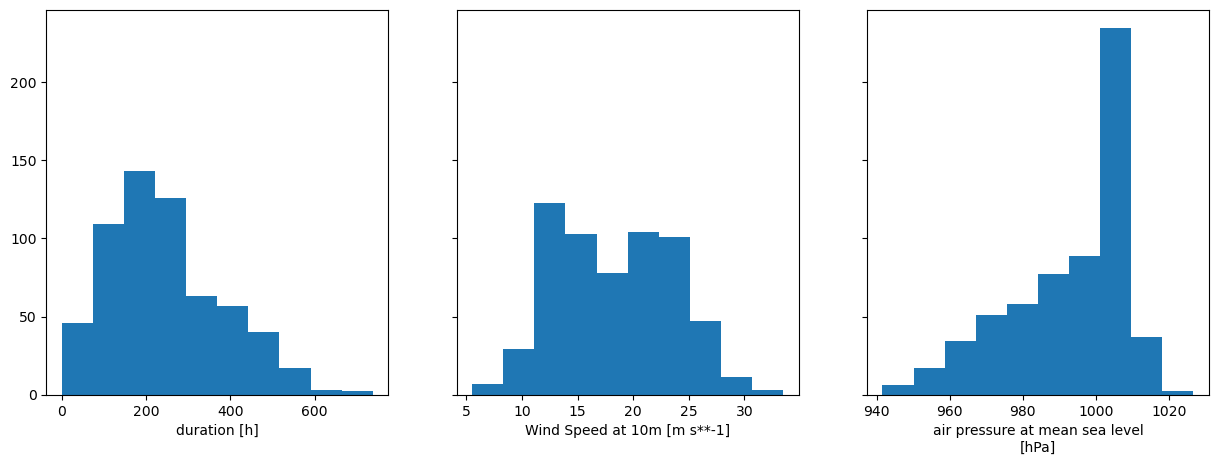

In [12]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=[15, 5])

# Duration
huracanpy.diags.track_stats.duration(data.time, data.track_id).plot.hist(ax=axs[0])

# Maximum wind speed
huracanpy.diags.track_stats.extremum_vals(
    data, varname="wind_speed_10m", stat="max"
).wind_speed_10m.plot.hist(ax=axs[1])

# Minimum SLP
huracanpy.diags.track_stats.extremum_vals(
    data, varname="psl", stat="min"
).psl.plot.hist(ax=axs[2])

## Lifecycles

In [13]:
# Compute times from extremum
data["time_from_slp_min"] = huracanpy.diags.lifecycle.time_from_extremum(
    data, varname="psl", stat="min"
)
data["time_from_wind_max"] = huracanpy.diags.lifecycle.time_from_extremum(
    data, varname="wind_speed_10m", stat="max"
)

<Axes: xlabel='time_from_wind_max', ylabel='wind_speed_10m'>

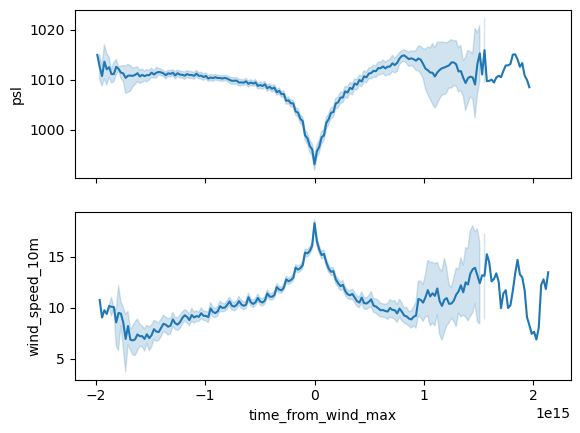

In [27]:
# Plot with seaborn
fig, axs = plt.subplots(2, sharex=True)
# SLP lifecycle
sns.lineplot(data=data, x="time_from_slp_min", y="psl", ax=axs[0])
# Wind lifecycle
sns.lineplot(data=data, x="time_from_wind_max", y="wind_speed_10m", ax=axs[1])

## Track density

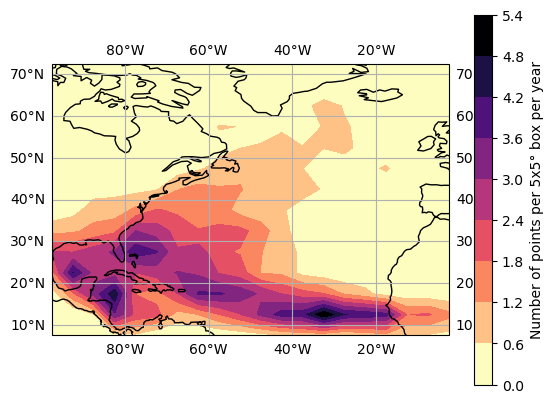

In [15]:
# Density of all points
d = huracanpy.diags.track_density.simple_global_histogram(
    data.longitude, data.latitude, N_seasons=data.season.nunique()
)
fig, ax = huracanpy.plot.density.plot_density(
    d,
    cbar_kwargs=dict(label="Number of points per 5x5° box per year"),
)

(<Figure size 640x480 with 2 Axes>, <GeoAxes: xlabel='lon', ylabel='lat'>)

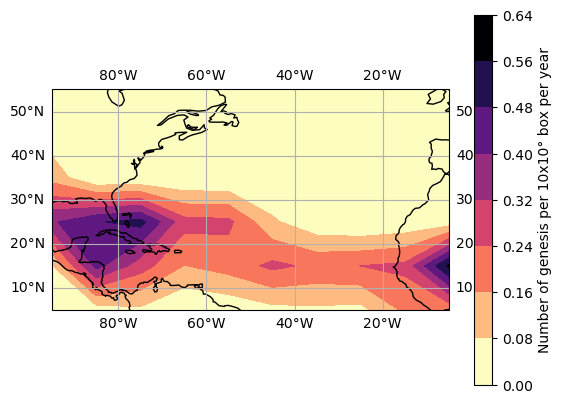

In [16]:
# Genesis density
gen = huracanpy.diags.track_stats.gen_vals(
    data
)  # Extract the point of genesis for each track
d = huracanpy.diags.track_density.simple_global_histogram(
    gen.longitude, gen.latitude, N_seasons=gen.season.nunique(), bin_size=10
)
huracanpy.plot.density.plot_density(
    d,
    cbar_kwargs=dict(label="Number of genesis per 10x10° box per year"),
)

## Translation speeds

In [17]:
translation_speeds = huracanpy.diags.translation_speed.translation_speed(
    data, lat_name="latitude", lon_name="longitude"
)

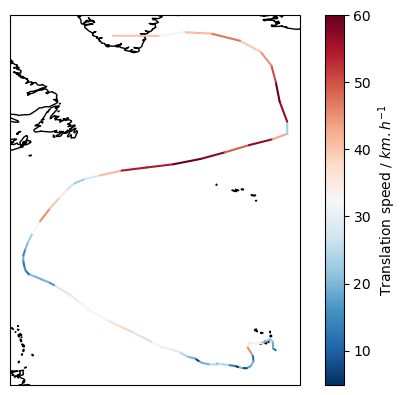

In [18]:
# Plot one track with its translation speed
## Subset one track
track = huracanpy.subset.sel_id(
    translation_speeds, tid="2010-9", track_id_name="track_id"
)
## Plot
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
p = huracanpy.plot.fancyline(
    track.lon, track.lat, track.translation_speed * 3.6, ax=ax, cmap="RdBu_r", vmax=60
)
plt.colorbar(p, label="Translation speed / $km.h^{-1}$")

Text(0, 0.5, 'translation speed / $m.s^{-1}$')

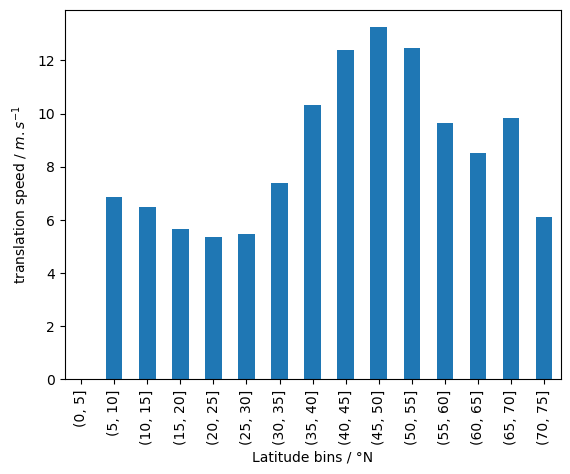

In [19]:
# Mean translation speed per latitude bins
translation_speeds.groupby_bins(
    "lat", bins=np.arange(0, 80, 5)
).mean(  # Compute mean translation speed per latitude bin
).translation_speed.to_series().plot.bar()  # Bar plot
# Plot customization
plt.xlabel("Latitude bins / °N")
plt.ylabel("translation speed / $m.s^{-1}$")

## Intensification rates

In [20]:
deepening_rate = huracanpy.diags.rates.rate(
    data, rate_var="psl", lat_name="latitude", lon_name="longitude"
)

/Users/bourdin/Softs/huracanpy/huracanpy/diags/rates.py:29: RuntimeWarning: divide by zero encountered in divide
  rate = (data[rate_var].values[1:] - data[rate_var].values[:-1]) / (


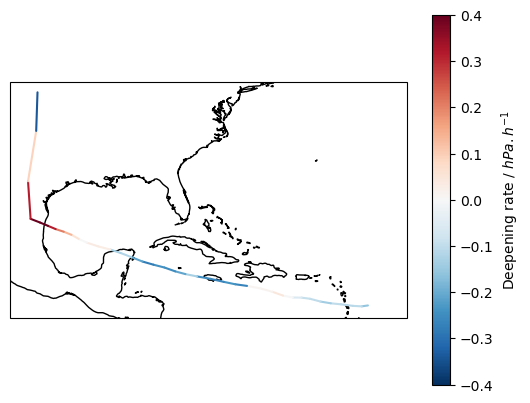

In [21]:
# Plot one track with its deepening rate
## Subset one track
track = huracanpy.subset.sel_id(deepening_rate, tid="1988-15", track_id_name="track_id")
## Plot
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
p = huracanpy.plot.fancyline(
    track.lon,
    track.lat,
    track.rate.rolling(
        mid_record=4, center=True
    ).mean(),  # Rolling mean of the rate for less noisy plot
    ax=ax,
    cmap="RdBu_r",
    vmin=-0.4,
    vmax=0.4,
)
plt.colorbar(p, label="Deepening rate / $hPa.h^{-1}$")

In [22]:
intensification_rate = huracanpy.diags.rates.rate(
    data, rate_var="wind_speed_10m", lat_name="latitude", lon_name="longitude"
)

/Users/bourdin/Softs/huracanpy/huracanpy/diags/rates.py:29: RuntimeWarning: divide by zero encountered in divide
  rate = (data[rate_var].values[1:] - data[rate_var].values[:-1]) / (


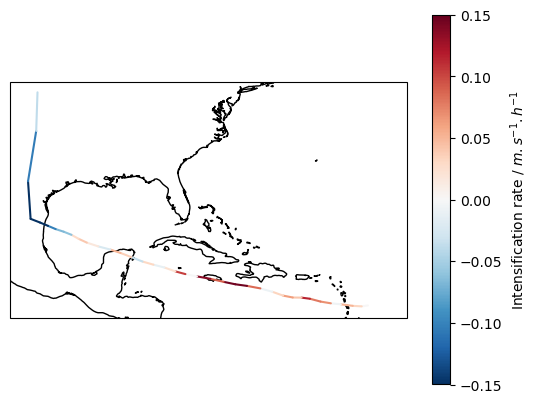

In [23]:
# Plot one track with its deepening rate
## Subset one track
track = huracanpy.subset.sel_id(
    intensification_rate, tid="1988-15", track_id_name="track_id"
)
## Plot
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
p = huracanpy.plot.fancyline(
    track.lon,
    track.lat,
    track.rate.rolling(
        mid_record=4, center=True
    ).mean(),  # Rolling mean of the rate for less noisy plot
    ax=ax,
    cmap="RdBu_r",
    vmin=-0.15,
    vmax=+0.15,
)
plt.colorbar(p, label="Intensification rate / $m.s^{-1}.h^{-1}$")

Text(0.5, 0, 'Maximum deepening rate / $hPa.h^{-1}$')

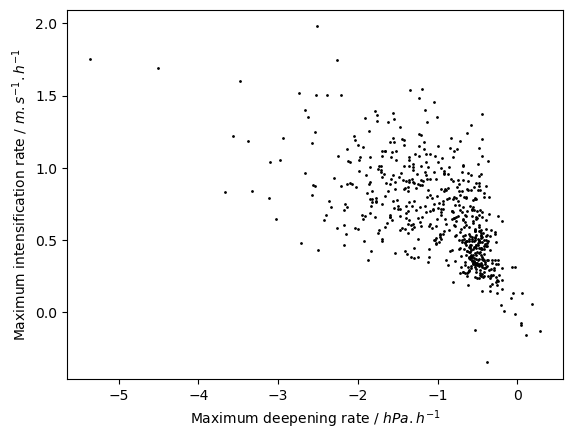

In [24]:
# Maximum intensification vs. deepening rate
plt.scatter(
    deepening_rate.where(~np.isnan(deepening_rate.rate), drop=True)
    .groupby("track_id")
    .min()
    .rate,
    intensification_rate.where(~np.isnan(intensification_rate.rate), drop=True)
    .groupby("track_id")
    .max()
    .rate,
    color="k",
    s=1,
)
plt.ylabel("Maximum intensification rate / $m.s^{-1}.h^{-1}$")
plt.xlabel("Maximum deepening rate / $hPa.h^{-1}$")